In [104]:
import numpy as np
import torch
from torch.nn.functional import cosine_similarity
import matplotlib.pyplot as plt
from tqdm import tqdm

node_directory = f'/data/jesse/node_classification/'
graph_directory = f'/data/jesse/graph_classification/'
add_directory = f'/data/jesse/additional_exp/'
node_datasets = ['Cora', 'Citeseer', 'Cornell', 'Texas', 'Wisconsin']
graph_datasets = ['MUTAG', 'PROTEINS', 'Graph-SST2']
architectures = ['GCN', 'GAT', 'GIN']
min_layers = 1
max_layers = 5
torch.manual_seed(0)

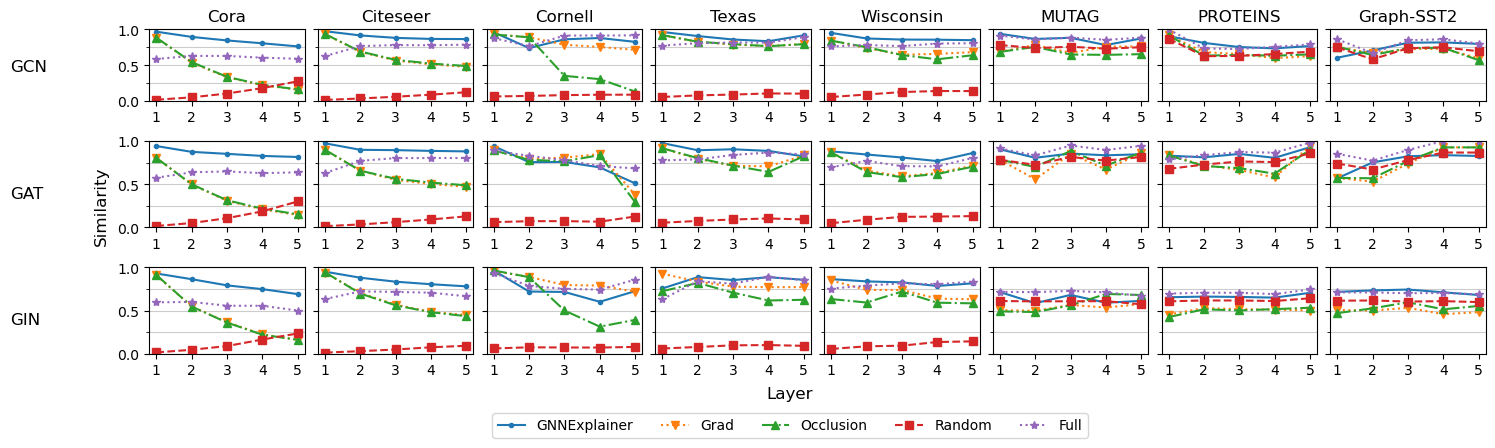

In [105]:
# Input-level similarities to 1{Grad > 0}
fig = plt.figure(figsize=(14, 4), constrained_layout=True)
subfigs = fig.subfigures(nrows=len(architectures), ncols=1)
cycler = plt.cycler(linestyle = ['solid', 'dotted', 'dashdot', 'dashed', 'dotted', 'dashdot'],
                    marker = ['.', 'v', '^', 's', '*', '.'],
                    color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:cyan'])

for i in range(len(architectures)):
    gnn_type = architectures[i]
    subfigs[i].suptitle(gnn_type, x = -0.075, y = 0.5, ha='left', va='center')
    axes = subfigs[i].subplots(nrows=1, ncols=len(node_datasets)+len(graph_datasets), sharey=True)
    for j in range(len(node_datasets)+len(graph_datasets)):
        axes[j].set_prop_cycle(cycler)
        if j < len(node_datasets):
            dataset = node_datasets[j]
            if i == 0:
                axes[j].set_title(node_datasets[j])
            means = []
            for layer in range(min_layers, max_layers + 1):
                gi_expls = torch.load(node_directory + dataset + f'/{gnn_type}_{layer}_layers_gi_preds.pt',
                                                map_location = 'cpu')
                occ_expls = torch.load(node_directory + dataset + f'/{gnn_type}_{layer}_layers_occ_preds.pt',
                                                map_location = 'cpu')
                gnn_expls = torch.load(node_directory + dataset + f'/{gnn_type}_{layer}_layers_gnnexplainer_preds.pt', 
                                                map_location = 'cpu')
                rand_expls = torch.load(node_directory + dataset + f'/{gnn_type}_{layer}_layers_rand_preds.pt',
                                                    map_location = 'cpu')
                full_expls = torch.load(node_directory + dataset + f'/{gnn_type}_{layer}_layers_full_preds.pt',
                                                    map_location = 'cpu')
                inds_to_compare = torch.any(gi_expls > 0, axis = 1)
                gi_pos = (gi_expls > 0)[inds_to_compare]
                means.append([
                    cosine_similarity(gnn_expls[inds_to_compare], gi_pos).mean(),
                    cosine_similarity(gi_expls[inds_to_compare], gi_pos).mean(),
                    cosine_similarity(occ_expls[inds_to_compare], gi_pos).mean(),
                    cosine_similarity(rand_expls[inds_to_compare], gi_pos).mean(),
                    cosine_similarity(full_expls[inds_to_compare,-1,:], gi_pos).mean(),
                ])
        else:
            if j == len(node_datasets)+len(graph_datasets) - 1:
                directory = add_directory
            else:
                directory = graph_directory
            dataset = graph_datasets[j-len(node_datasets)]
            if i == 0:
                axes[j].set_title(dataset)
            means = []
            for layer in range(min_layers, max_layers + 1):
                gi_expls = torch.load(directory + dataset + f'/{gnn_type}_{layer}_layers_gi_preds.pt', map_location = 'cpu')
                occ_expls = torch.load(directory + dataset + f'/{gnn_type}_{layer}_layers_occ_preds.pt', map_location = 'cpu')
                gnn_expls = torch.load(directory + dataset + f'/{gnn_type}_{layer}_layers_gnnexplainer_preds.pt', map_location = 'cpu')
                rand_expls = torch.load(directory + dataset + f'/{gnn_type}_{layer}_layers_rand_preds.pt', map_location = 'cpu')
                sims = []
                for gi_expl, occ_expl, gnn_expl, rand_expl in zip(gi_expls, occ_expls, gnn_expls, rand_expls):
                    full = torch.ones_like(gi_expl)
                    gi_pos = (gi_expl > 0).float()
                    if torch.any(gi_pos):
                        sims.append([
                            cosine_similarity(gnn_expl, gi_pos)[0],
                            cosine_similarity(gi_expl, gi_pos)[0],
                            cosine_similarity(occ_expl, gi_pos)[0],
                            cosine_similarity(rand_expl, gi_pos)[0],
                            cosine_similarity(full, gi_pos)[0],
                        ])
                sims = np.array(sims)
                if len(sims) > 0:
                    means.append(sims.mean(0))
                else:
                    means.append(np.full(5, np.nan))
        means = np.array(means)
        lines = axes[j].plot(range(min_layers, max_layers + 1), means)
        axes[j].set_ylim(0,1)
        axes[j].set_xticks(range(1, 6))
        axes[j].set_yticks([0.0, 0.5, 1.0])
        axes[j].set_yticks([0.0, 0.25, 0.5, 0.75, 1.0], minor=True)
        axes[j].grid(axis='y', which='both', color='0.8')

fig.legend(handles = lines, labels = [r'GNNExplainer', 'Grad', 'Occlusion', 'Random', 'Full'],
           loc = 'lower center', bbox_to_anchor=(0.5, -.1), ncol = 5)
fig.supxlabel('Layer')
fig.supylabel('Similarity')
plt.savefig('../images/input_similarities.svg')
plt.show()

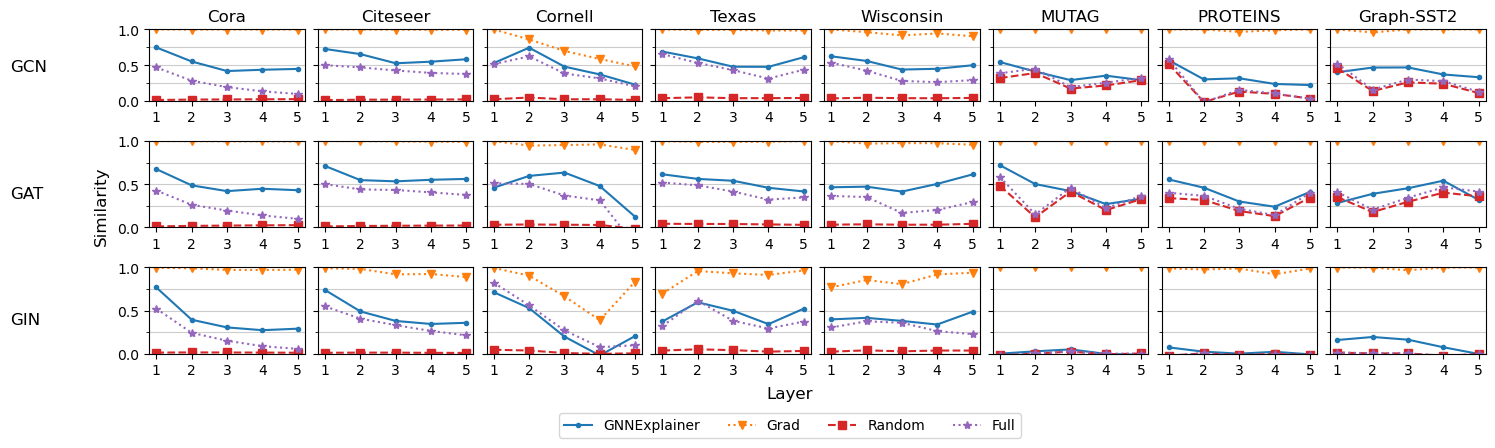

In [106]:
# Layerwise similarities to Occlusion
fig = plt.figure(figsize=(14, 4), constrained_layout=True)
subfigs = fig.subfigures(nrows=3, ncols=1)
cycler = plt.cycler(linestyle = ['solid', 'dotted', 'dashed', 'dotted', 'dashdot'],
                    marker = ['.', 'v', 's', '*', '.'],
                    color = ['tab:blue', 'tab:orange', 'tab:red', 'tab:purple', 'tab:cyan'])
for i in range(len(architectures)):
    gnn_type = architectures[i]
    subfigs[i].suptitle(gnn_type, x = -0.075, y = 0.5, ha='left', va='center')
    axes = subfigs[i].subplots(nrows=1, ncols=len(node_datasets)+len(graph_datasets), sharey=True)
    for j in range(len(node_datasets)+len(graph_datasets)):
        axes[j].set_prop_cycle(cycler)
        if j < len(node_datasets):
            dataset = node_datasets[j]
            if i == 0:
                axes[j].set_title(node_datasets[j])
            means = []
            for layer in range(min_layers, max_layers + 1):
                l_gi_expls = torch.load(node_directory + dataset + f'/{gnn_type}_{layer}_layers_layerwise_grad_preds.pt', map_location = 'cpu')
                l_occ_expls = torch.load(node_directory + dataset + f'/{gnn_type}_{layer}_layers_layerwise_occ_preds.pt', map_location = 'cpu')
                l_gnn_expls = torch.load(node_directory + dataset + f'/{gnn_type}_{layer}_layers_gnnexplainer_layerwise_preds.pt', map_location = 'cpu')
                l_full_expls = torch.load(node_directory + dataset + f'/{gnn_type}_{layer}_layers_full_preds.pt', map_location = 'cpu')
                l_rand_expls = torch.rand_like(l_full_expls)
                sims = []
                for gi_expl, occ_expl, gnn_expl, rand_expl, full_expl in zip(l_gi_expls, l_occ_expls, l_gnn_expls, l_rand_expls, l_full_expls):
                    if torch.any(occ_expl != 0):
                        sims.append([
                            cosine_similarity(gnn_expl.flatten(), occ_expl.flatten(), 0),
                            cosine_similarity(gi_expl.flatten(), occ_expl.flatten(), 0),
                            cosine_similarity(rand_expl.flatten(), occ_expl.flatten(), 0),
                            cosine_similarity(full_expl.flatten(), occ_expl.flatten(), 0),
                        ])
                sims = np.array(sims)
                means.append(sims.mean(0))
        else:
            if j == len(node_datasets)+len(graph_datasets) - 1:
                directory = add_directory
            else:
                directory = graph_directory
            dataset = graph_datasets[j-len(node_datasets)]
            if i == 0:
                axes[j].set_title(dataset)
            means = []
            for layer in range(min_layers, max_layers + 1):
                l_gi_expls = torch.load(directory + dataset + f'/{gnn_type}_{layer}_layers_l_grad_layerwise_preds.pt', map_location = 'cpu')
                l_occ_expls = torch.load(directory + dataset + f'/{gnn_type}_{layer}_layers_l_occ_layerwise_preds.pt', map_location = 'cpu')
                l_gnn_expls = torch.load(directory + dataset + f'/{gnn_type}_{layer}_layers_gnnexplainer_layerwise_preds.pt', map_location = 'cpu')
                sims = []
                for gi_expl, occ_expl, gnn_expl in zip(l_gi_expls, l_occ_expls, l_gnn_expls):
                    full = torch.ones_like(gi_expl)
                    rand = torch.rand_like(full)
                    sims.append([
                        cosine_similarity(gnn_expl.flatten(), occ_expl.flatten(), 0),
                        cosine_similarity(gi_expl.flatten(), occ_expl.flatten(), 0),
                        cosine_similarity(rand.flatten(), occ_expl.flatten(), 0),
                        cosine_similarity(full.flatten(), occ_expl.flatten(), 0),
                    ])
                sims = np.array(sims)
                if len(sims) > 0:
                    means.append(sims.mean(0))
                else:
                    means.append(np.full(4, np.nan))
        means = np.array(means)
        lines = axes[j].plot(range(min_layers, max_layers + 1), means)
        axes[j].set_ylim(0,1)
        axes[j].set_xticks(range(1, 6))
        axes[j].set_yticks([0.0, 0.5, 1.0])
        axes[j].set_yticks([0.0, 0.25, 0.5, 0.75, 1.0], minor=True)
        axes[j].grid(axis='y', which='both', color='0.8')
fig.legend(handles = lines, labels = [r'GNNExplainer', 'Grad', 'Random', 'Full'],
           loc = 'lower center', bbox_to_anchor=(0.5, -.1), ncol = 4)
fig.supxlabel('Layer')
fig.supylabel('Similarity')
plt.savefig('../images/layerwise_similarities.svg')
plt.show()

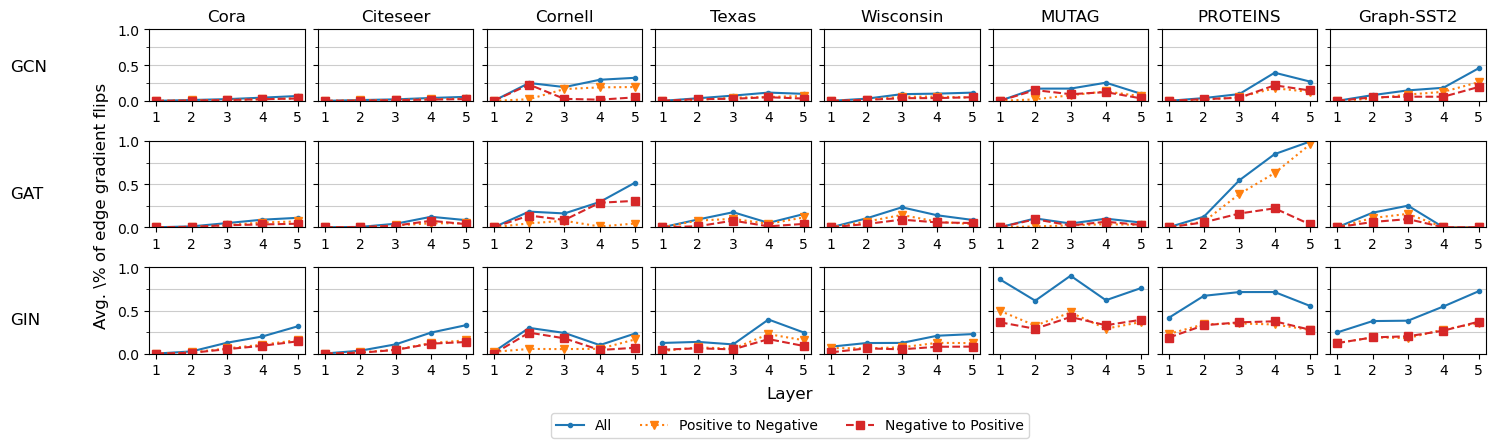

In [107]:
# Plot gradient flips per layer
cycler = plt.cycler(linestyle = ['solid', 'dotted', 'dashed', 'dotted', 'dashdot'],
                    marker = ['.', 'v', 's', '*', '.'],
                    color = ['tab:blue', 'tab:orange', 'tab:red', 'tab:purple', 'tab:cyan'])
fig = plt.figure(figsize=(14, 4), constrained_layout=True)
subfigs = fig.subfigures(nrows=3, ncols=1)
# fig.suptitle('Node Classification Datasets')

new_directory = f'/data/jesse/new_gradient_flips/'
for i in range(len(architectures)):
    gnn_type = architectures[i]
    subfigs[i].suptitle(gnn_type, x = -0.075, y = 0.5, ha='left', va='center')
    axes = subfigs[i].subplots(nrows=1, ncols=len(node_datasets)+len(graph_datasets), sharey=True)
    for j in range(len(node_datasets)+len(graph_datasets)):
        axes[j].set_prop_cycle(cycler)
        if j < len(node_datasets):
            dataset = node_datasets[j]
            if i == 0:
                axes[j].set_title(node_datasets[j])
            try:
                axes[j].set_prop_cycle(cycler)
                means = []
                for num_layers in range(min_layers, max_layers + 1):
                    gi_expls = torch.load(node_directory + dataset + f'/{gnn_type}_{num_layers}_layers_gi_preds.pt', map_location = 'cpu')
                    flips = torch.load(node_directory + dataset + f'/{gnn_type}_{num_layers}_grad_flips.pt', map_location = 'cpu')
                    pos_to_neg = torch.load(node_directory + dataset + f'/{gnn_type}_{num_layers}_pos_to_neg_flips.pt', map_location = 'cpu')
                    neg_to_pos = torch.load(node_directory + dataset + f'/{gnn_type}_{num_layers}_neg_to_pos_flips.pt', map_location = 'cpu')
                    mask = torch.where(gi_expls != 0.)[0]
                    means.append([float((flips.sum(1) / (gi_expls != 0.).sum(1))[mask].mean()),
                                float((pos_to_neg.sum(1) / (gi_expls != 0.).sum(1))[mask].mean()),
                                float((neg_to_pos.sum(1) / (gi_expls != 0.).sum(1))[mask].mean())
                                ])
                lines = axes[j].plot(range(min_layers, max_layers + 1), means)
            except FileNotFoundError:
                pass
        else:
            if j == len(node_datasets)+len(graph_datasets) - 1:
                directory = add_directory
            else:
                directory = graph_directory
            dataset = graph_datasets[j-len(node_datasets)]
            if i == 0:
                axes[j].set_title(dataset)
            try:
                axes[j].set_prop_cycle(cycler)
                means = []
                for num_layers in range(min_layers, max_layers + 1):
                    gi_expls = torch.load(directory + dataset + f'/{gnn_type}_{num_layers}_layers_gi_preds.pt', map_location = 'cpu')
                    flips = torch.load(new_directory + dataset + f'/{gnn_type}_{num_layers}_grad_flips.pt', map_location = 'cpu')
                    pos_to_neg = torch.load(new_directory + dataset + f'/{gnn_type}_{num_layers}_pos_to_neg_flips.pt', map_location = 'cpu')
                    neg_to_pos = torch.load(new_directory + dataset + f'/{gnn_type}_{num_layers}_neg_to_pos_flips.pt', map_location = 'cpu')
                    percents = []
                    for gi_expl, flip, p2n, n2p in zip(gi_expls, flips, pos_to_neg, neg_to_pos):
                        if (gi_expl != 0.).sum() > 0:
                            percents.append([float(flip.sum() / (gi_expl != 0.).sum()),
                                    float(p2n.sum() / (gi_expl != 0.).sum()),
                                    float(n2p.sum() / (gi_expl != 0.).sum())
                                    ])
                    percents = np.array(percents)
                    means.append(percents.mean(0))
                lines = axes[j].plot(range(min_layers, max_layers + 1), means)
            except FileNotFoundError:
                pass
        axes[j].set_ylim(0,1)
        axes[j].set_xticks(range(1, 6))
        axes[j].set_yticks([0.0, 0.5, 1.0])
        axes[j].set_yticks([0.0, 0.25, 0.5, 0.75, 1.0], minor=True)
        axes[j].grid(axis='y', which='both', color='0.8')
fig.legend(handles = lines, labels = [r'All', 'Positive to Negative', 'Negative to Positive'],
           loc = 'lower center', bbox_to_anchor=(0.5, -.1), ncol = 4)
fig.supxlabel('Layer')
fig.supylabel('Avg. \% of edge gradient flips')
plt.savefig('../images/grad_flips.svg')
plt.show()

In [108]:
# Qualitative comparison of input-level explanations
from torch_geometric.datasets import Planetoid, WebKB
from torch_geometric.utils import k_hop_subgraph
import networkx as nx
from matplotlib import colormaps, cm, colors
gnn_type = 'GCN'
dataset = 'Cora'
layer = 2

data = Planetoid(
        root = '/data/jesse/',
        name = dataset,
        split = 'geom-gcn'
    )
data = data[0]
data.test_mask = data.test_mask[:,0].bool()
node_indices = torch.where(data.test_mask)[0].reshape(-1,1)

gi_expls = torch.load(node_directory + dataset + f'/{gnn_type}_{layer}_layers_gi_preds.pt',
                                                map_location = 'cpu')
gi_pos = gi_expls > 0
gnn_expls = torch.load(node_directory + dataset + f'/{gnn_type}_{layer}_layers_gnnexplainer_preds.pt', 
                                                map_location = 'cpu')

Similarity: 0.9570946097373962


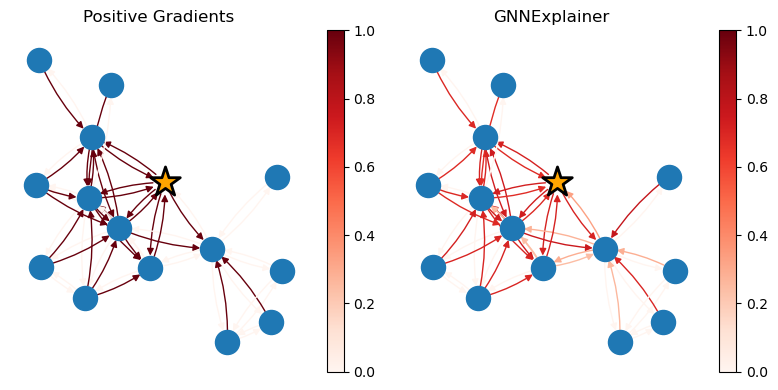

In [119]:
idx = 0
print(f'Similarity: {float(cosine_similarity(gi_pos[idx].flatten(), gnn_expls[idx].flatten(), 0))}')
node_index = node_indices[idx]
neighbors, _, _, hard_edge_mask = k_hop_subgraph(node_index, layer, data.edge_index)
edge_index = data.edge_index[:, hard_edge_mask].cpu()
edge_list = []
G = nx.DiGraph()
for j in range(edge_index.shape[1]):
    G.add_edge(int(edge_index[0,j]), int(edge_index[1,j]))
    edge_list.append((int(edge_index[0,j]), int(edge_index[1,j])))

gi_pos_mask_dict = {edge_list[j] : float(gi_pos[idx,hard_edge_mask][j])
                for j in range(G.number_of_edges())}
gnn_mask_dict = {edge_list[j] : float(gnn_expls[idx,hard_edge_mask][j])
                for j in range(G.number_of_edges())}
nx.set_edge_attributes(G, gi_pos_mask_dict, 'Positive Gradients')
nx.set_edge_attributes(G, gnn_mask_dict, 'GNNExplainer')

pos = nx.kamada_kawai_layout(G)
fig, ax = plt.subplots(1, 2, figsize=(8,4))
node_list = list(G.nodes)
node_list.remove(int(node_index))

for i in range(2):
    nx.draw_networkx_nodes(G, pos, ax=ax[i],
                       nodelist = node_list)
    nx.draw_networkx_nodes(G, pos, ax=ax[i],
                           node_shape='*',
                           node_color = 'orange',
                           node_size=500, linewidths = 2., edgecolors='black', 
                           nodelist = [int(node_index)])
gi_pos_edges = nx.draw_networkx_edges(G, pos=pos, ax = ax[0],
                       connectionstyle='arc3, rad = 0.1',
              edge_color = [G[u][v]['Positive Gradients'] for u,v in G.edges],
              edge_cmap = colormaps['Reds'], edge_vmin = 0, edge_vmax = 1)
gnn_edges = nx.draw_networkx_edges(G, pos=pos, ax = ax[1],
                       connectionstyle='arc3, rad = 0.1',
              edge_color = [G[u][v]['GNNExplainer'] for u,v in G.edges],
              edge_cmap = colormaps['Reds'], edge_vmin = 0, edge_vmax = 1)
fig.colorbar(
    cm.ScalarMappable(colors.Normalize(vmin = 0, vmax = 1),
                             cmap=colormaps['Reds']),
    ax=ax[0])
fig.colorbar(
    cm.ScalarMappable(colors.Normalize(vmin = 0, vmax = 1),
                             cmap=colormaps['Reds']),
    ax=ax[1])
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[0].title.set_text('Positive Gradients')
ax[1].title.set_text('GNNExplainer')
fig.tight_layout()
plt.savefig(f'../images/{dataset}_qualitative.svg')